In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.datasets import load_svmlight_file
import re
import itertools
from scipy import stats
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer

In [7]:
sns.set_context('talk')

In [8]:
if os.path.split(os.getcwd())[-1] == 'notebooks': os.chdir(os.path.split(os.getcwd())[-2])
print(os.getcwd())

/home/fitzaudoen/apps/gas-sensor-analytics-demo


# Format of the .dat file

from https://archive.ics.uci.edu/ml/datasets/Gas+Sensor+Array+Drift+Dataset+at+Different+Concentrations#
"For processing purposes, the dataset is organized into ten batches, each containing the number of measurements per class and month indicated in the tables below. This reorganization of data was done to ensure having a sufficient and as uniformly distributed as possible number of experiments in each batch.

The dataset is organized in files, each representing a different batch. Within the files, each line represents a measurement. The first character (1-6) codes the analyte, followed by the concentration level:

1: Ethanol; 2: Ethylene; 3: Ammonia; 4: Acetaldehyde; 5: Acetone; 6: Toluene

The data format follows the same coding style as in libsvm format x:v, where x stands for the feature number and v for the actual value of the feature. For example, in
1;10.000000 1:15596.162100 2:1.868245 3:2.371604 4:2.803678 5:7.512213 â€¦ 128:-2.654529

The number 1 stands for the class number (in this case Ethanol), the gas concentration level was 10ppmv, and the remaining 128 columns list the actual feature values for each measurement recording organized as described above.

"

In [9]:
files = os.listdir(os.path.join(os.getcwd(),'data/raw/'))
files = [file for file in files if file.split('.')[-1] == 'dat']

In [10]:
print(files)

['batch1.dat', 'batch10.dat', 'batch2.dat', 'batch3.dat', 'batch4.dat', 'batch5.dat', 'batch6.dat', 'batch7.dat', 'batch8.dat', 'batch9.dat']


### Note on sample_no
The dataset description explains that sensor drift over time is expected to be an important feature. There's no indication of any timestamp or regular time delta between the tests, so it is assume that the order of the tests is a proxy the time the test was taken. The description does indicate that each batch was collected over consecutive months. 

In [11]:
data = []
sample_no = 1
for batch in range(1,11):
    with open(os.path.join(os.getcwd(),'data/raw','batch{}.dat'.format(batch))) as file:  # the a opens it in append mode
        for line in file:
            line = line.strip()
            line = line.split(' ')
            #print(line)
            #print('\n')
            labels = [label for label in line[0].split(';')]
            line_data = [float(datum.split(':')[1]) for datum in line[1:]]
            line_data_feature_no = [str(int(datum.split(':')[0])) for datum in line[1:]]

            #for datum in line[1:]: data[int(datum.split(':')[0])] = float(datum.split(':')[1])  
            #print(line_data_labels)
            #print(line_data)
            #print('\n')
            #print('\n')
            if len(labels) !=2: print('not two labels')
            if len(line_data_feature_no ) != 128: print('not 128 features')
            #if line_data_feature_no != list(range(1,129)): print('lables misordered')

            data.append([batch]+labels+[sample_no]+line_data)
            sample_no+=1

# Add mnemonic ID labels and feature names

In [11]:
chemical_names = {'1':'Ethanol', '2':'Ethylene', '3':'Ammonia', '4':'Acetaldehyde', '5':'Acetone', '6':'Toluene'}

In [12]:
# According to description of the data, the sensor array data is composted of 8 sensors with each sensor response
# summarized into 16 metrics
feature_names = ['s{sensor_id}_f{feature_id}'.format(sensor_id=sensor_id,feature_id=feature_id) for
                sensor_id, feature_id in itertools.product(range(1,9),range(1,17))]

In [13]:
columns = ['Batch_ID','Gas_ID','Gas_Conc','sample_no']  + feature_names
df = pd.DataFrame(data,columns=columns)

In [14]:
for k, v in chemical_names.items():
    df.loc[df.Gas_ID == k,'Gas_ID'] = v

NameError: name 'chemical_names' is not defined

# Data Exploration

In [15]:
melt_df = df.melt(id_vars=(['Batch_ID','Gas_ID','Gas_Conc']),var_name = 'sensor_feature', value_name ='sensor_value')

The sensor responses exhibit strong skew/fat-tailed distribution. Due to how non-gaussian the data are, standard scalar is unlikely properly each response to a consistent range (The mean and standard deviation will scale features with different amounts of skew differntly).

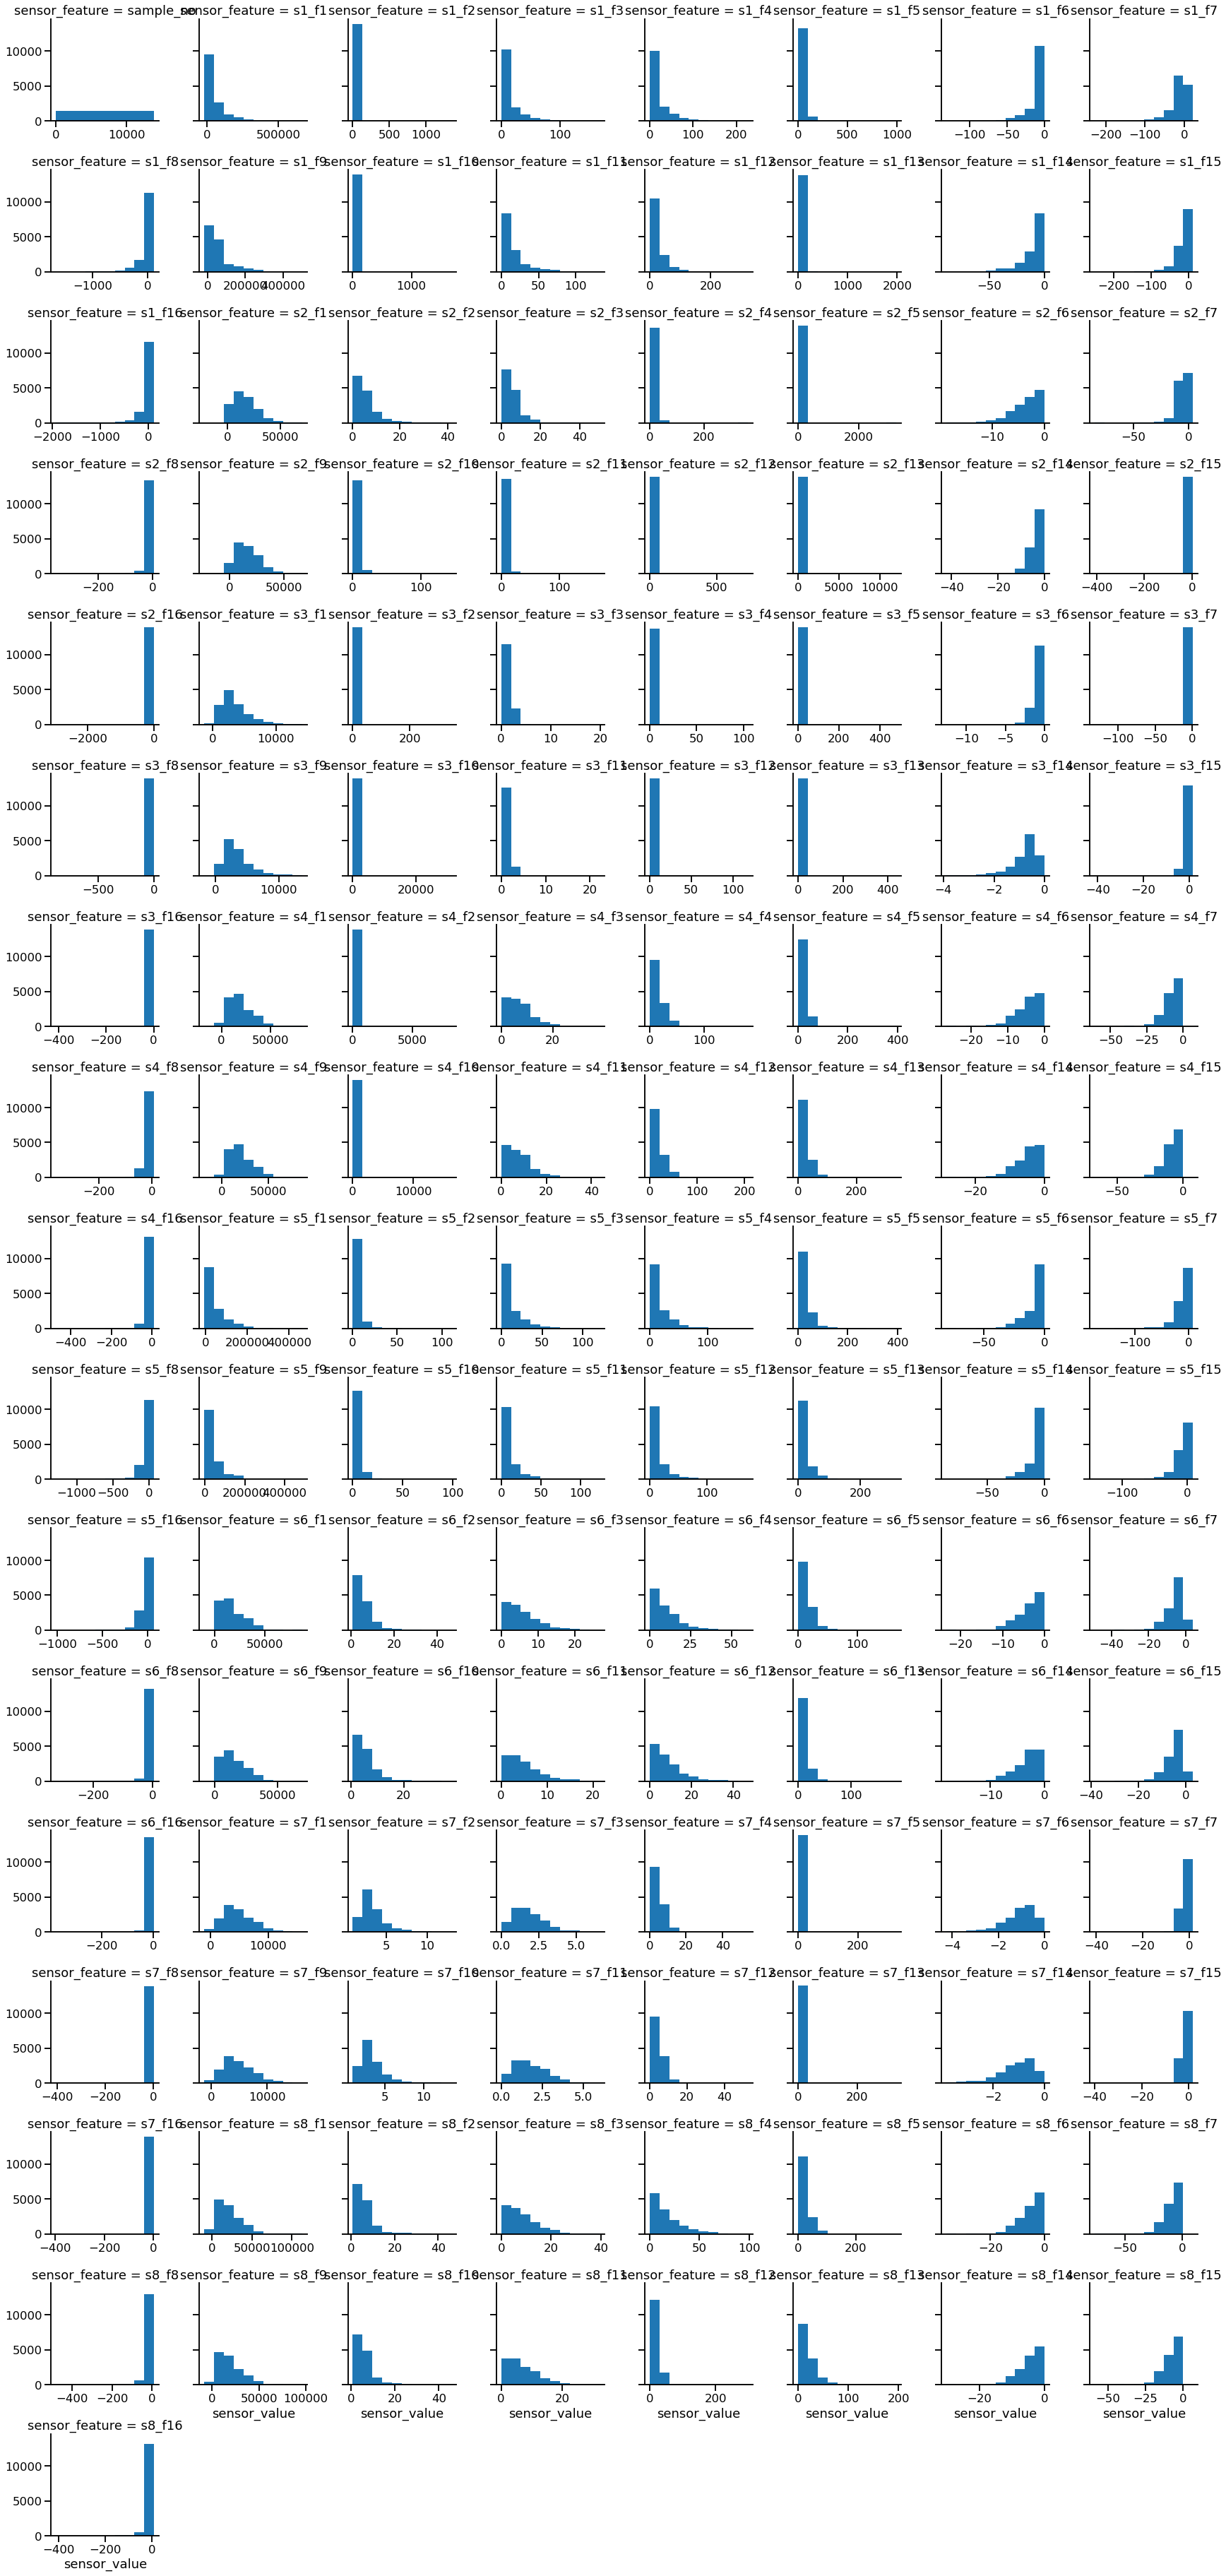

In [16]:
g = sns.FacetGrid(melt_df, col='sensor_feature', col_wrap=8, sharex=False)
g.map(plt.hist,'sensor_value')

## Select Z value cut-off for outliers / presumed bad sensor readings

Even when filtering the high end of the data based on Z-score, the distributions are still clearly highly skewed

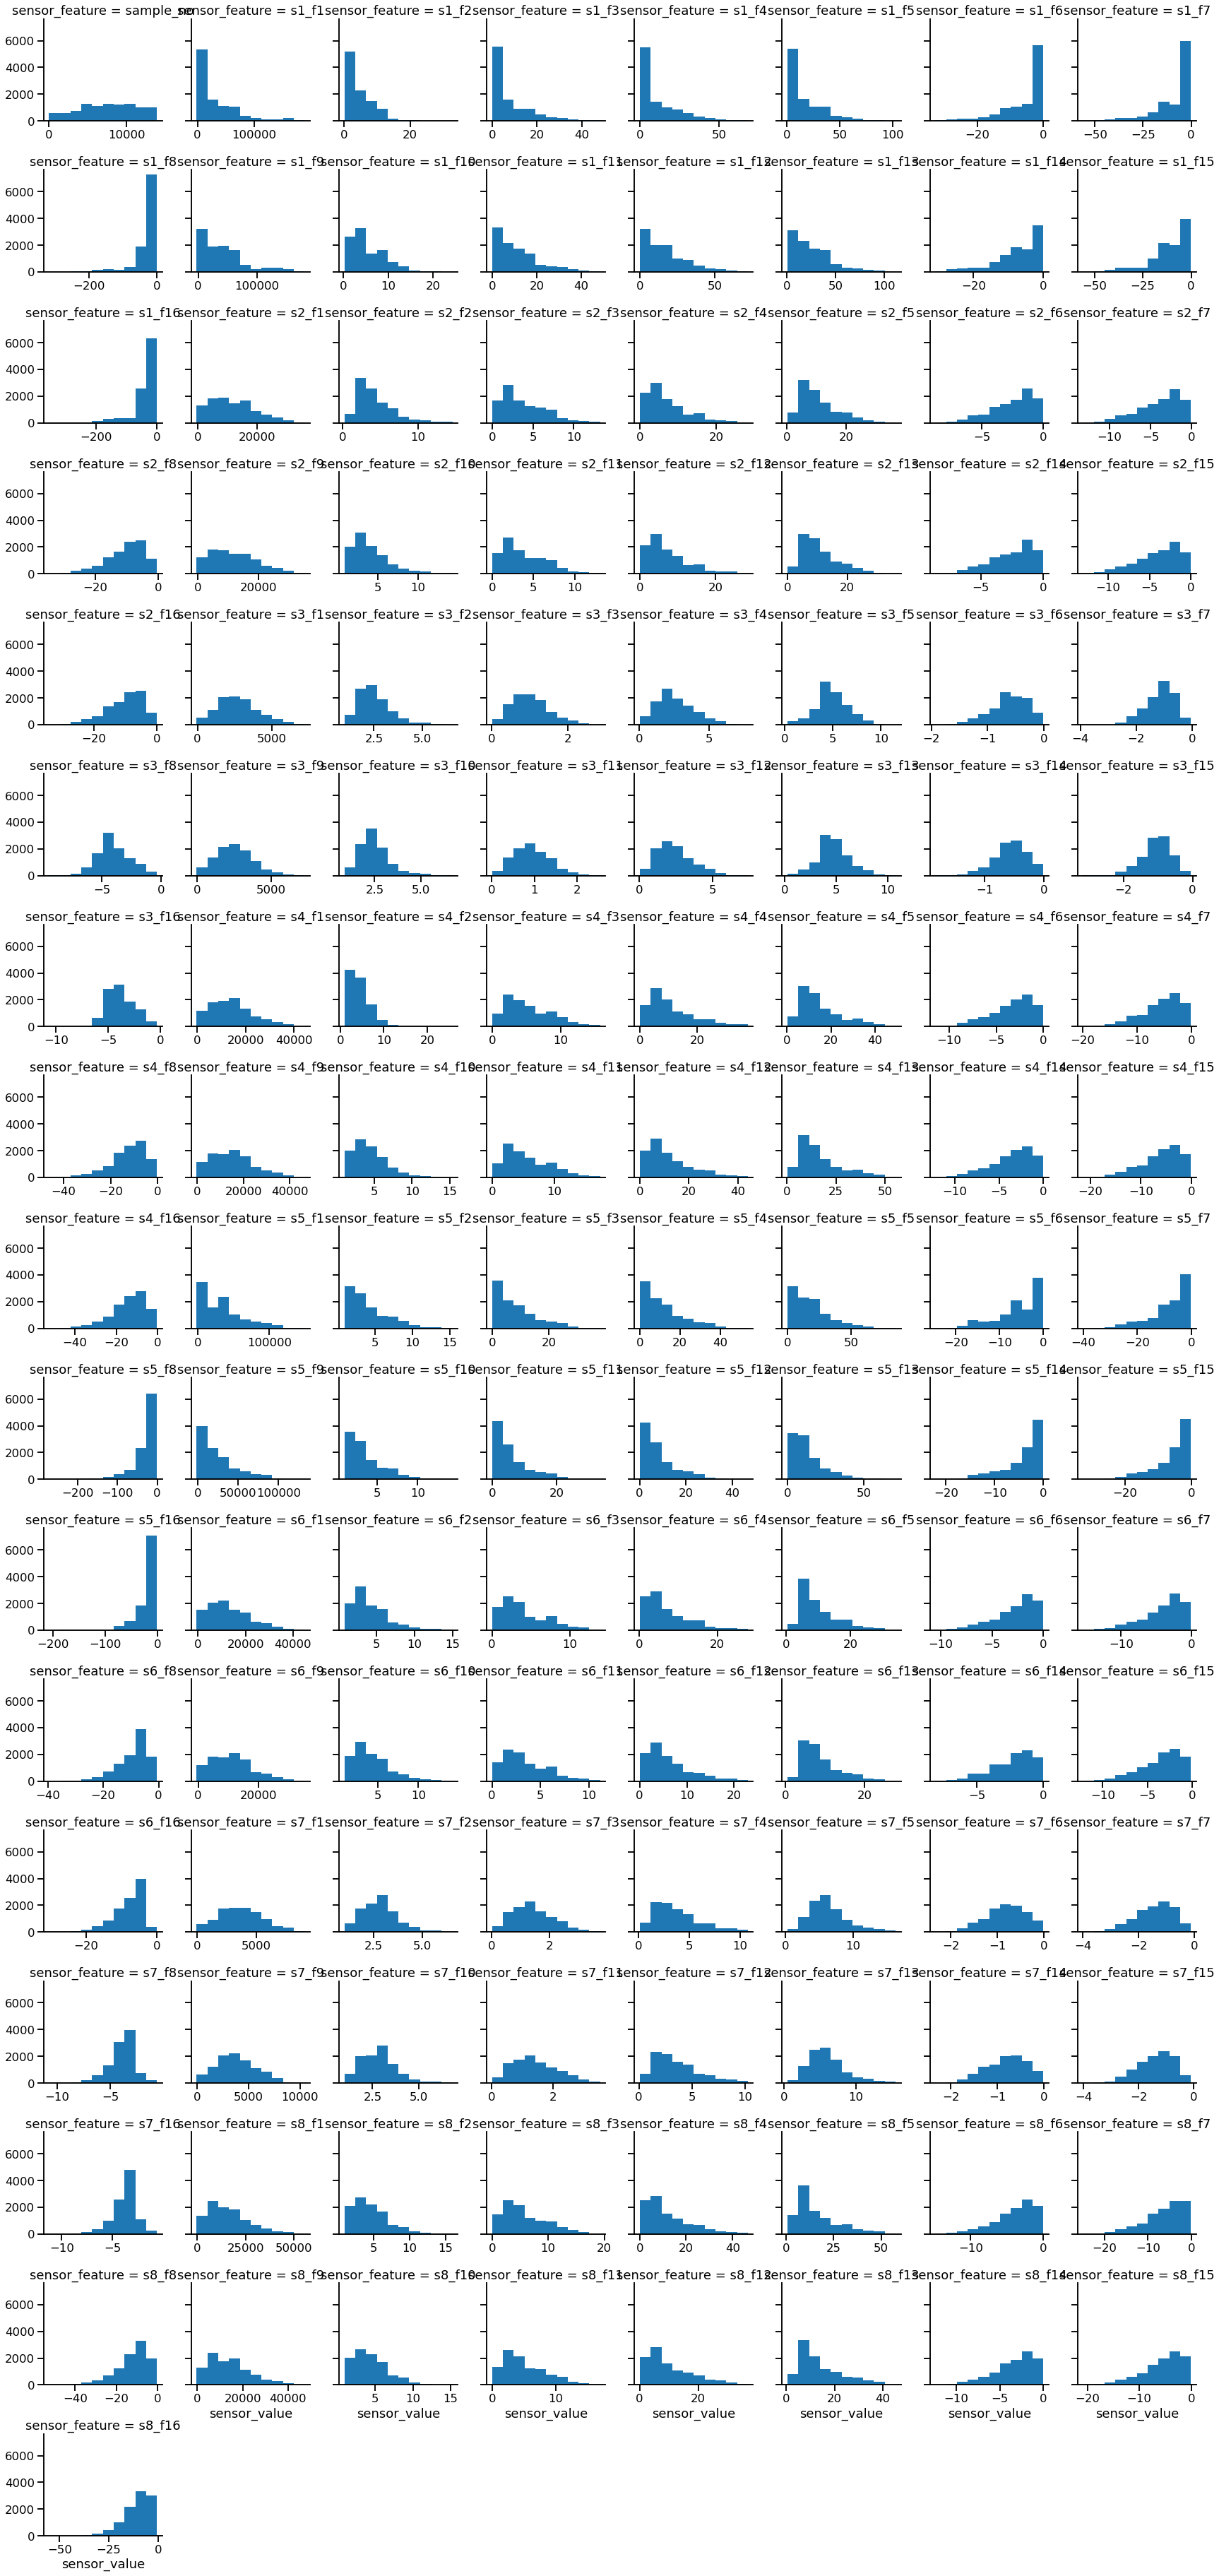

In [19]:
filter_df = df[(np.abs(stats.zscore(df.loc[:,feature_names])) < 2).all(axis=1)]
filter_melt_df = filter_df.melt(id_vars=(['Batch_ID','Gas_ID','Gas_Conc']),var_name = 'sensor_feature', value_name ='sensor_value')
g = sns.FacetGrid(filter_melt_df, col='sensor_feature', col_wrap=8, sharex=False)
g.map(plt.hist,'sensor_value')

## Split Data

In [20]:
train, testing = train_test_split(df, test_size=0.4, random_state=42, shuffle=True)

In [21]:
cross_validation, test = train_test_split(testing, test_size=0.5, random_state=42, shuffle=True)

# Scaling

In [35]:
scaler = StandardScaler()
rscaler = RobustScaler()
pscaler = PowerTransformer()

In [25]:
X_scale = scaler.fit_transform(df[df.columns.values[4:]])

In [29]:
scale_df = pd.DataFrame(X_scale, columns = df.columns.values[4:])

Standard scaler does a poor job of bringing the features into a consistent range

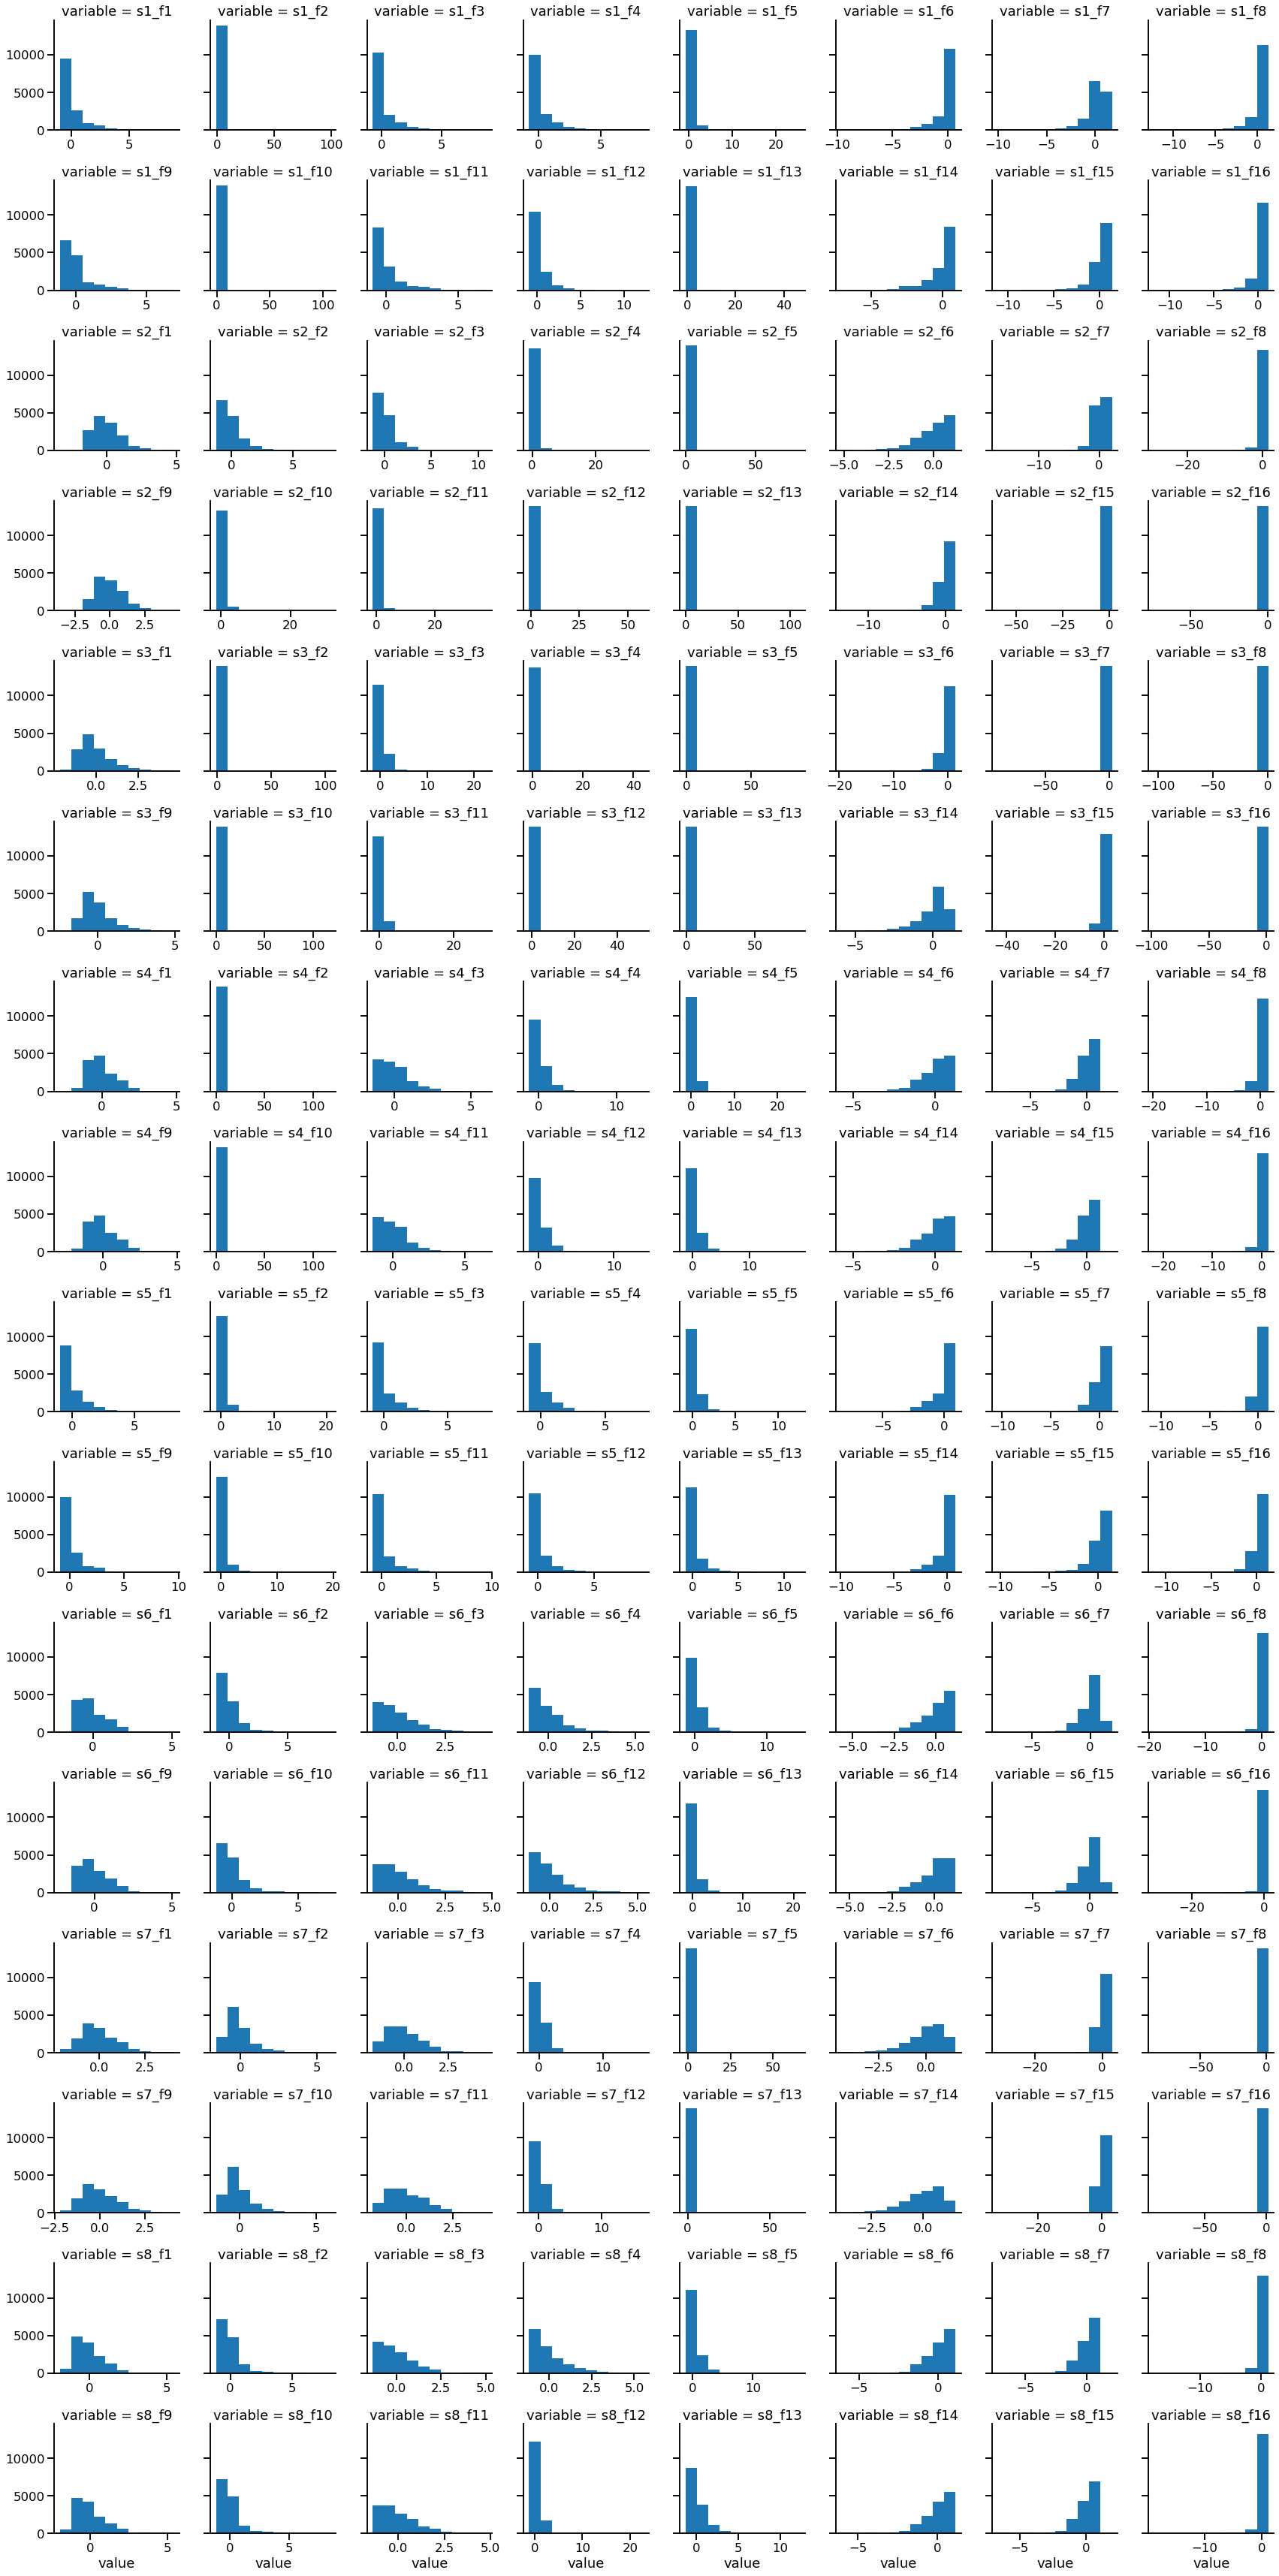

In [32]:
g = sns.FacetGrid(pd.melt(scale_df), col='variable', col_wrap=8, sharex=False)
g.map(plt.hist,'value')

Tried robust scaler and the high skew still causes issues in scaling the data

In [33]:
X_rscale = rscaler.fit_transform(df[df.columns.values[4:]])
rscale_df = pd.DataFrame(X_rscale, columns = df.columns.values[4:])

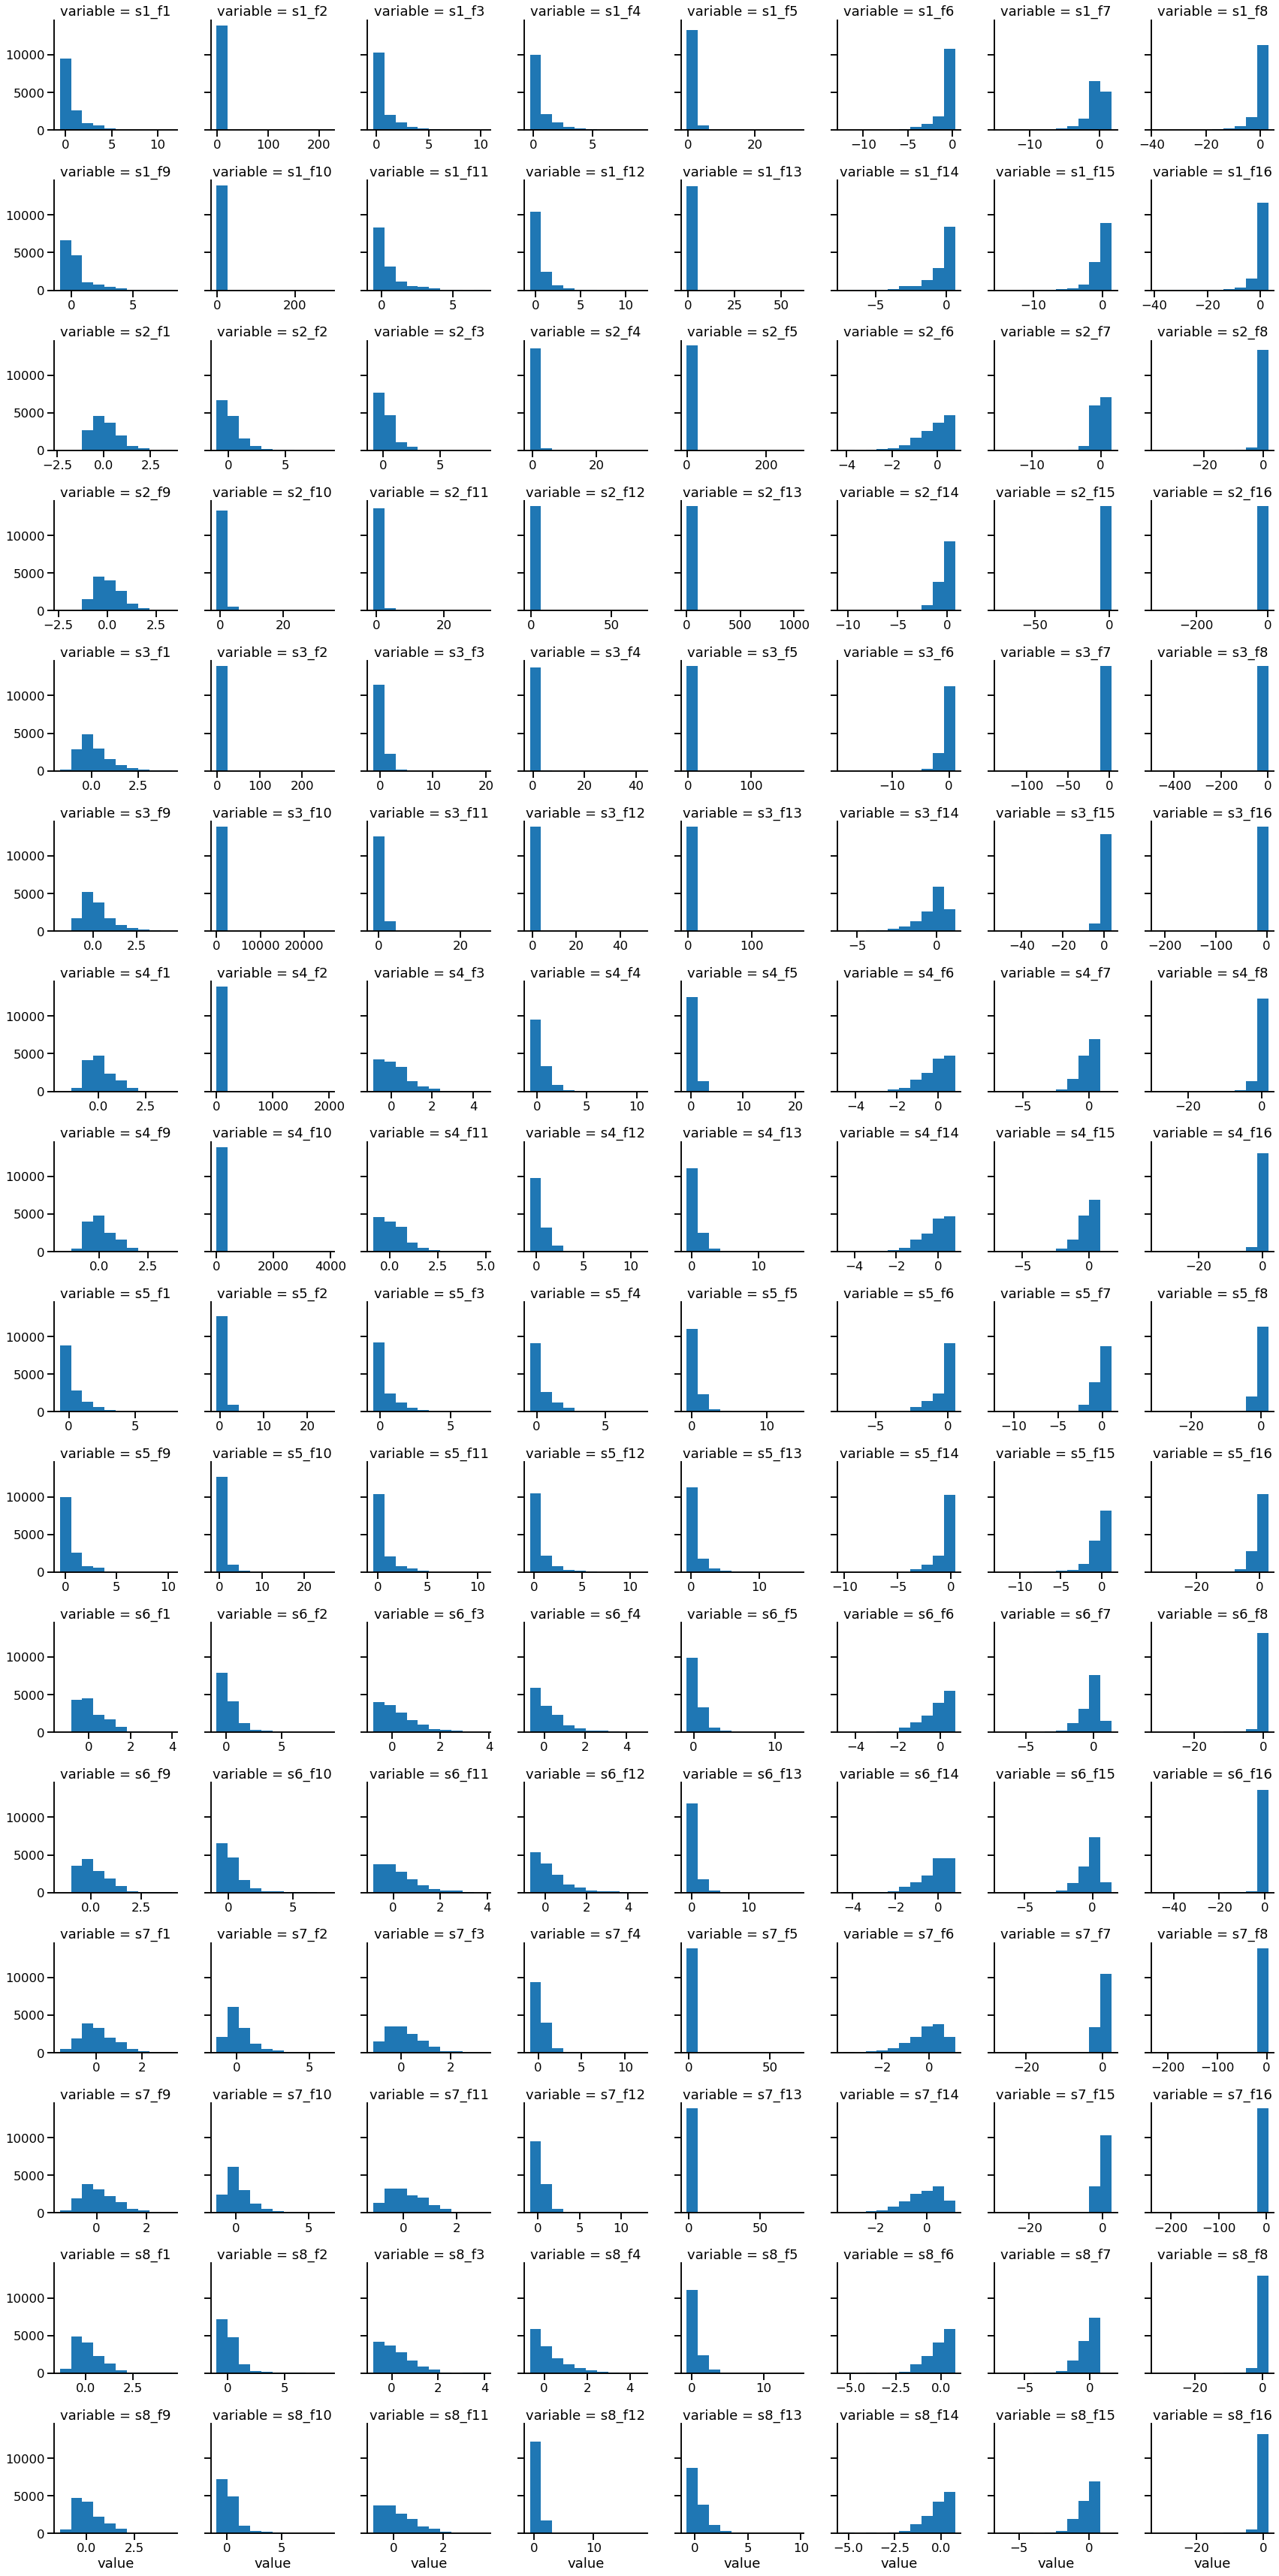

In [34]:
g = sns.FacetGrid(pd.melt(rscale_df), col='variable', col_wrap=8, sharex=False)
g.map(plt.hist,'value')

Power transform does succeed in turning the data into a gaussian looking distributions that are in a consistent range. However, there does appear to be some outliers causing some large ranges in features. 

In [36]:
X_pscale = pscaler.fit_transform(df[df.columns.values[4:]])
pscale_df = pd.DataFrame(X_pscale, columns = df.columns.values[4:])

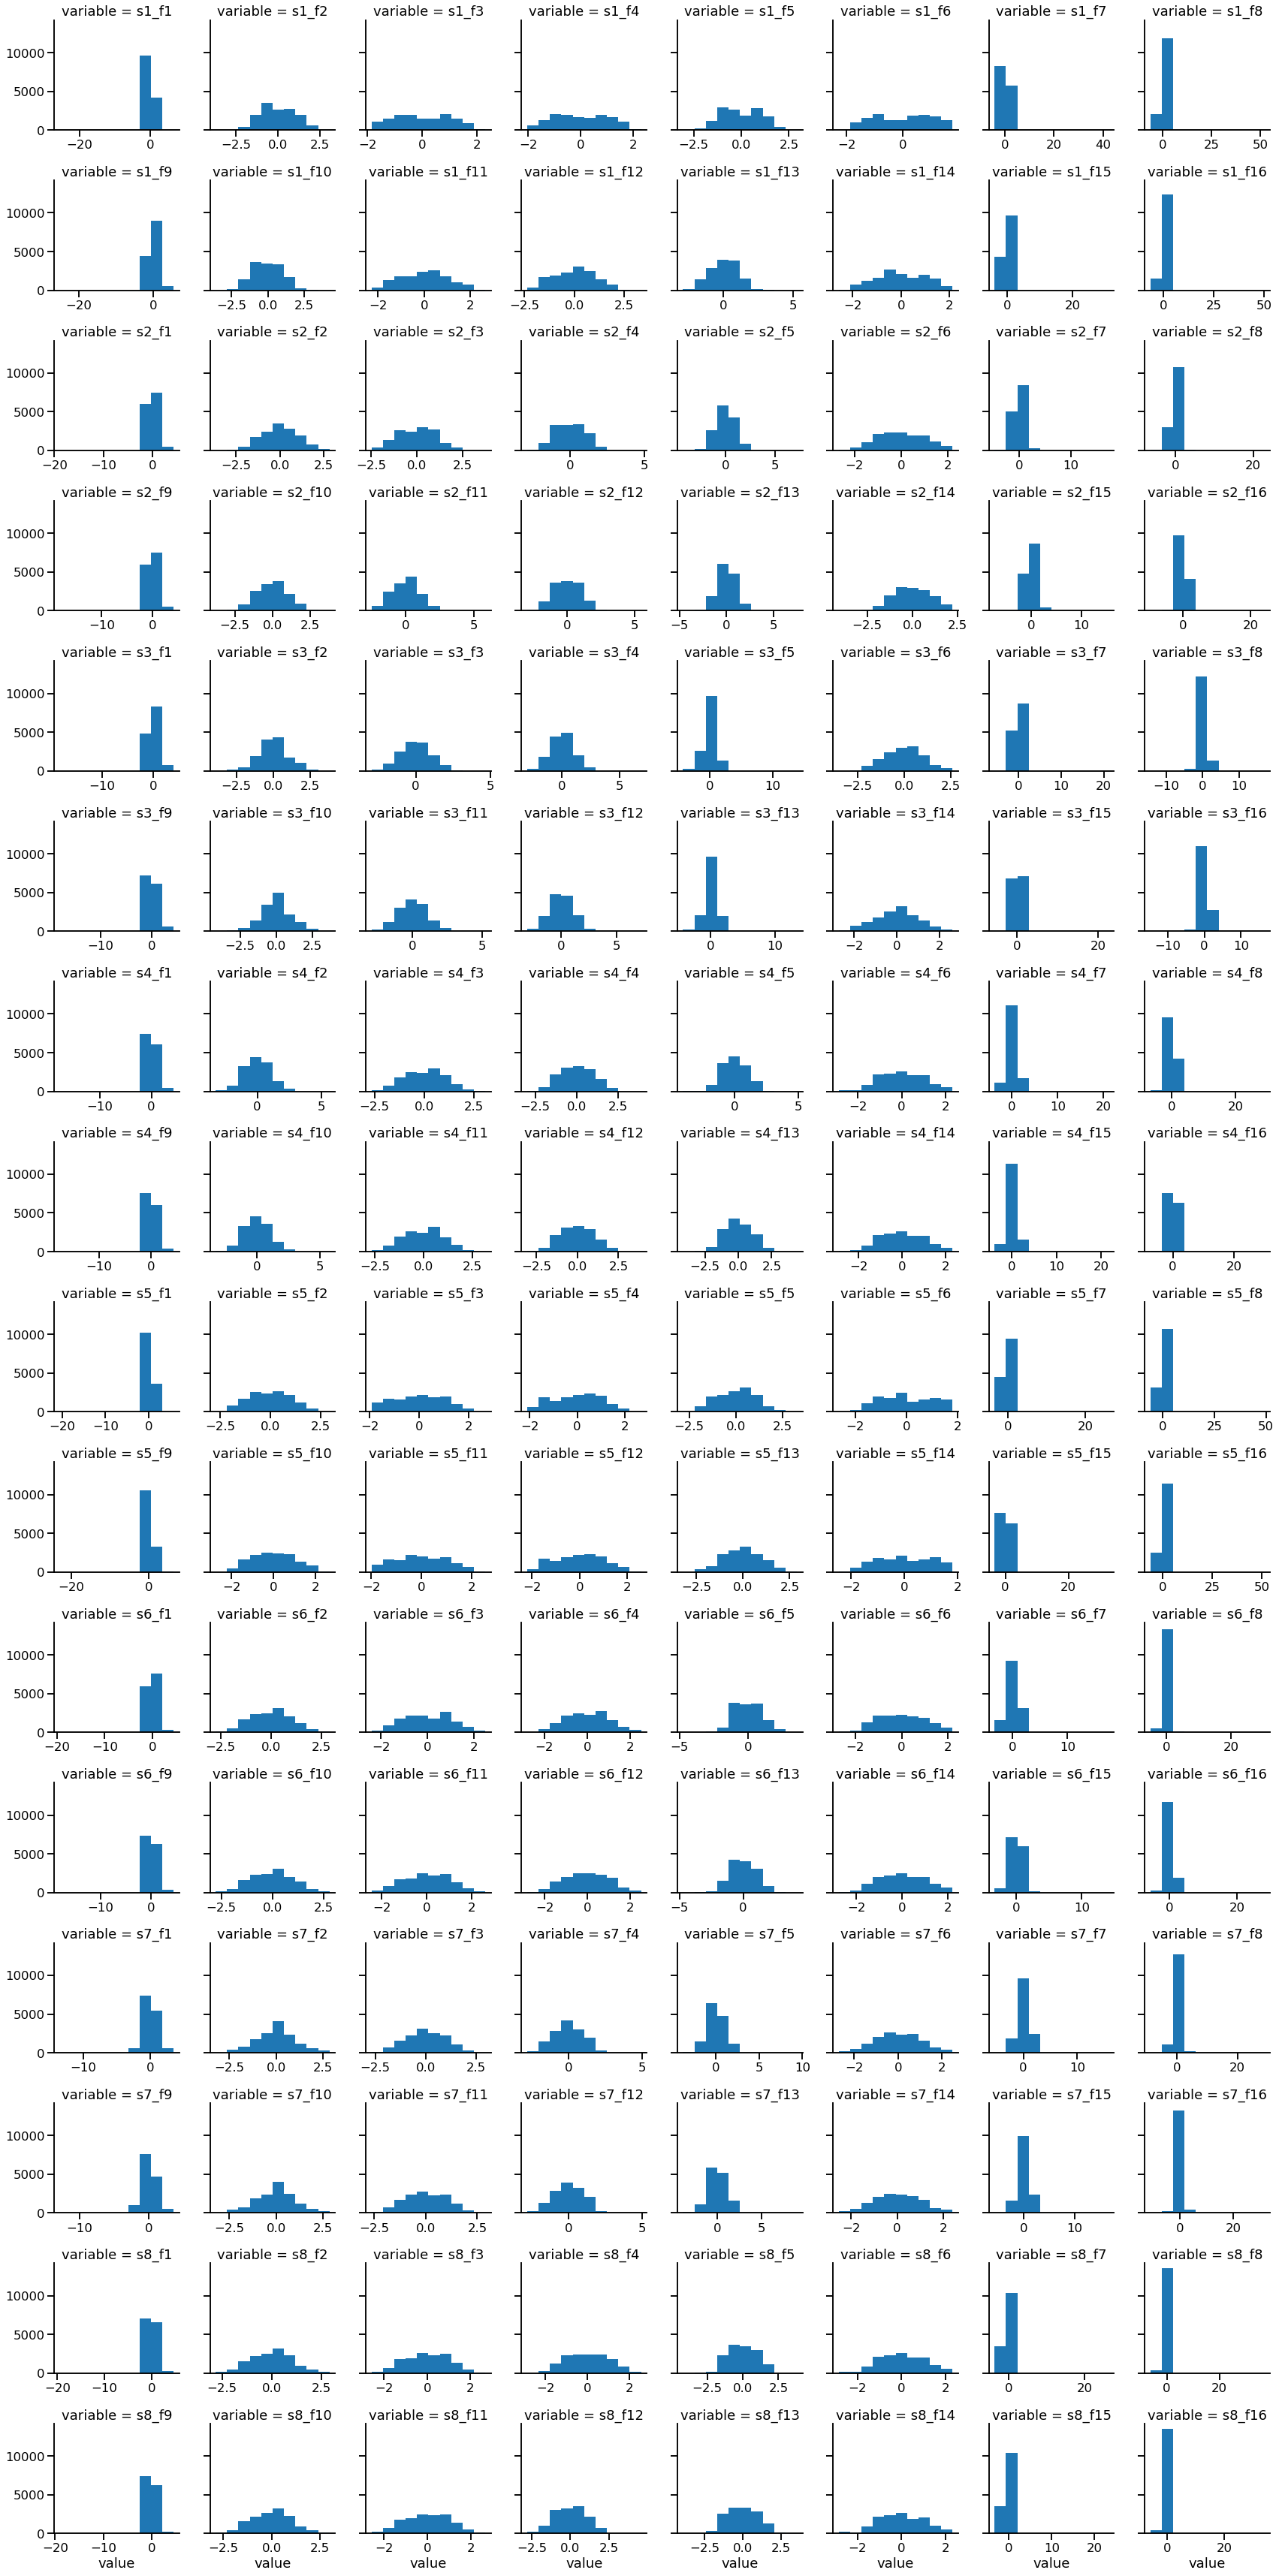

In [37]:
g = sns.FacetGrid(pd.melt(pscale_df), col='variable', col_wrap=8, sharex=False)
g.map(plt.hist,'value')

Filtering Z values does a good job of brining all the features into nice distributions of a similar range. Most are uniformly distribution, while some still exhibit some amount of skew.

In [38]:
filter_pscale_df = pscale_df[(np.abs(stats.zscore(pscale_df.loc[:,feature_names])) < 3).all(axis=1)]

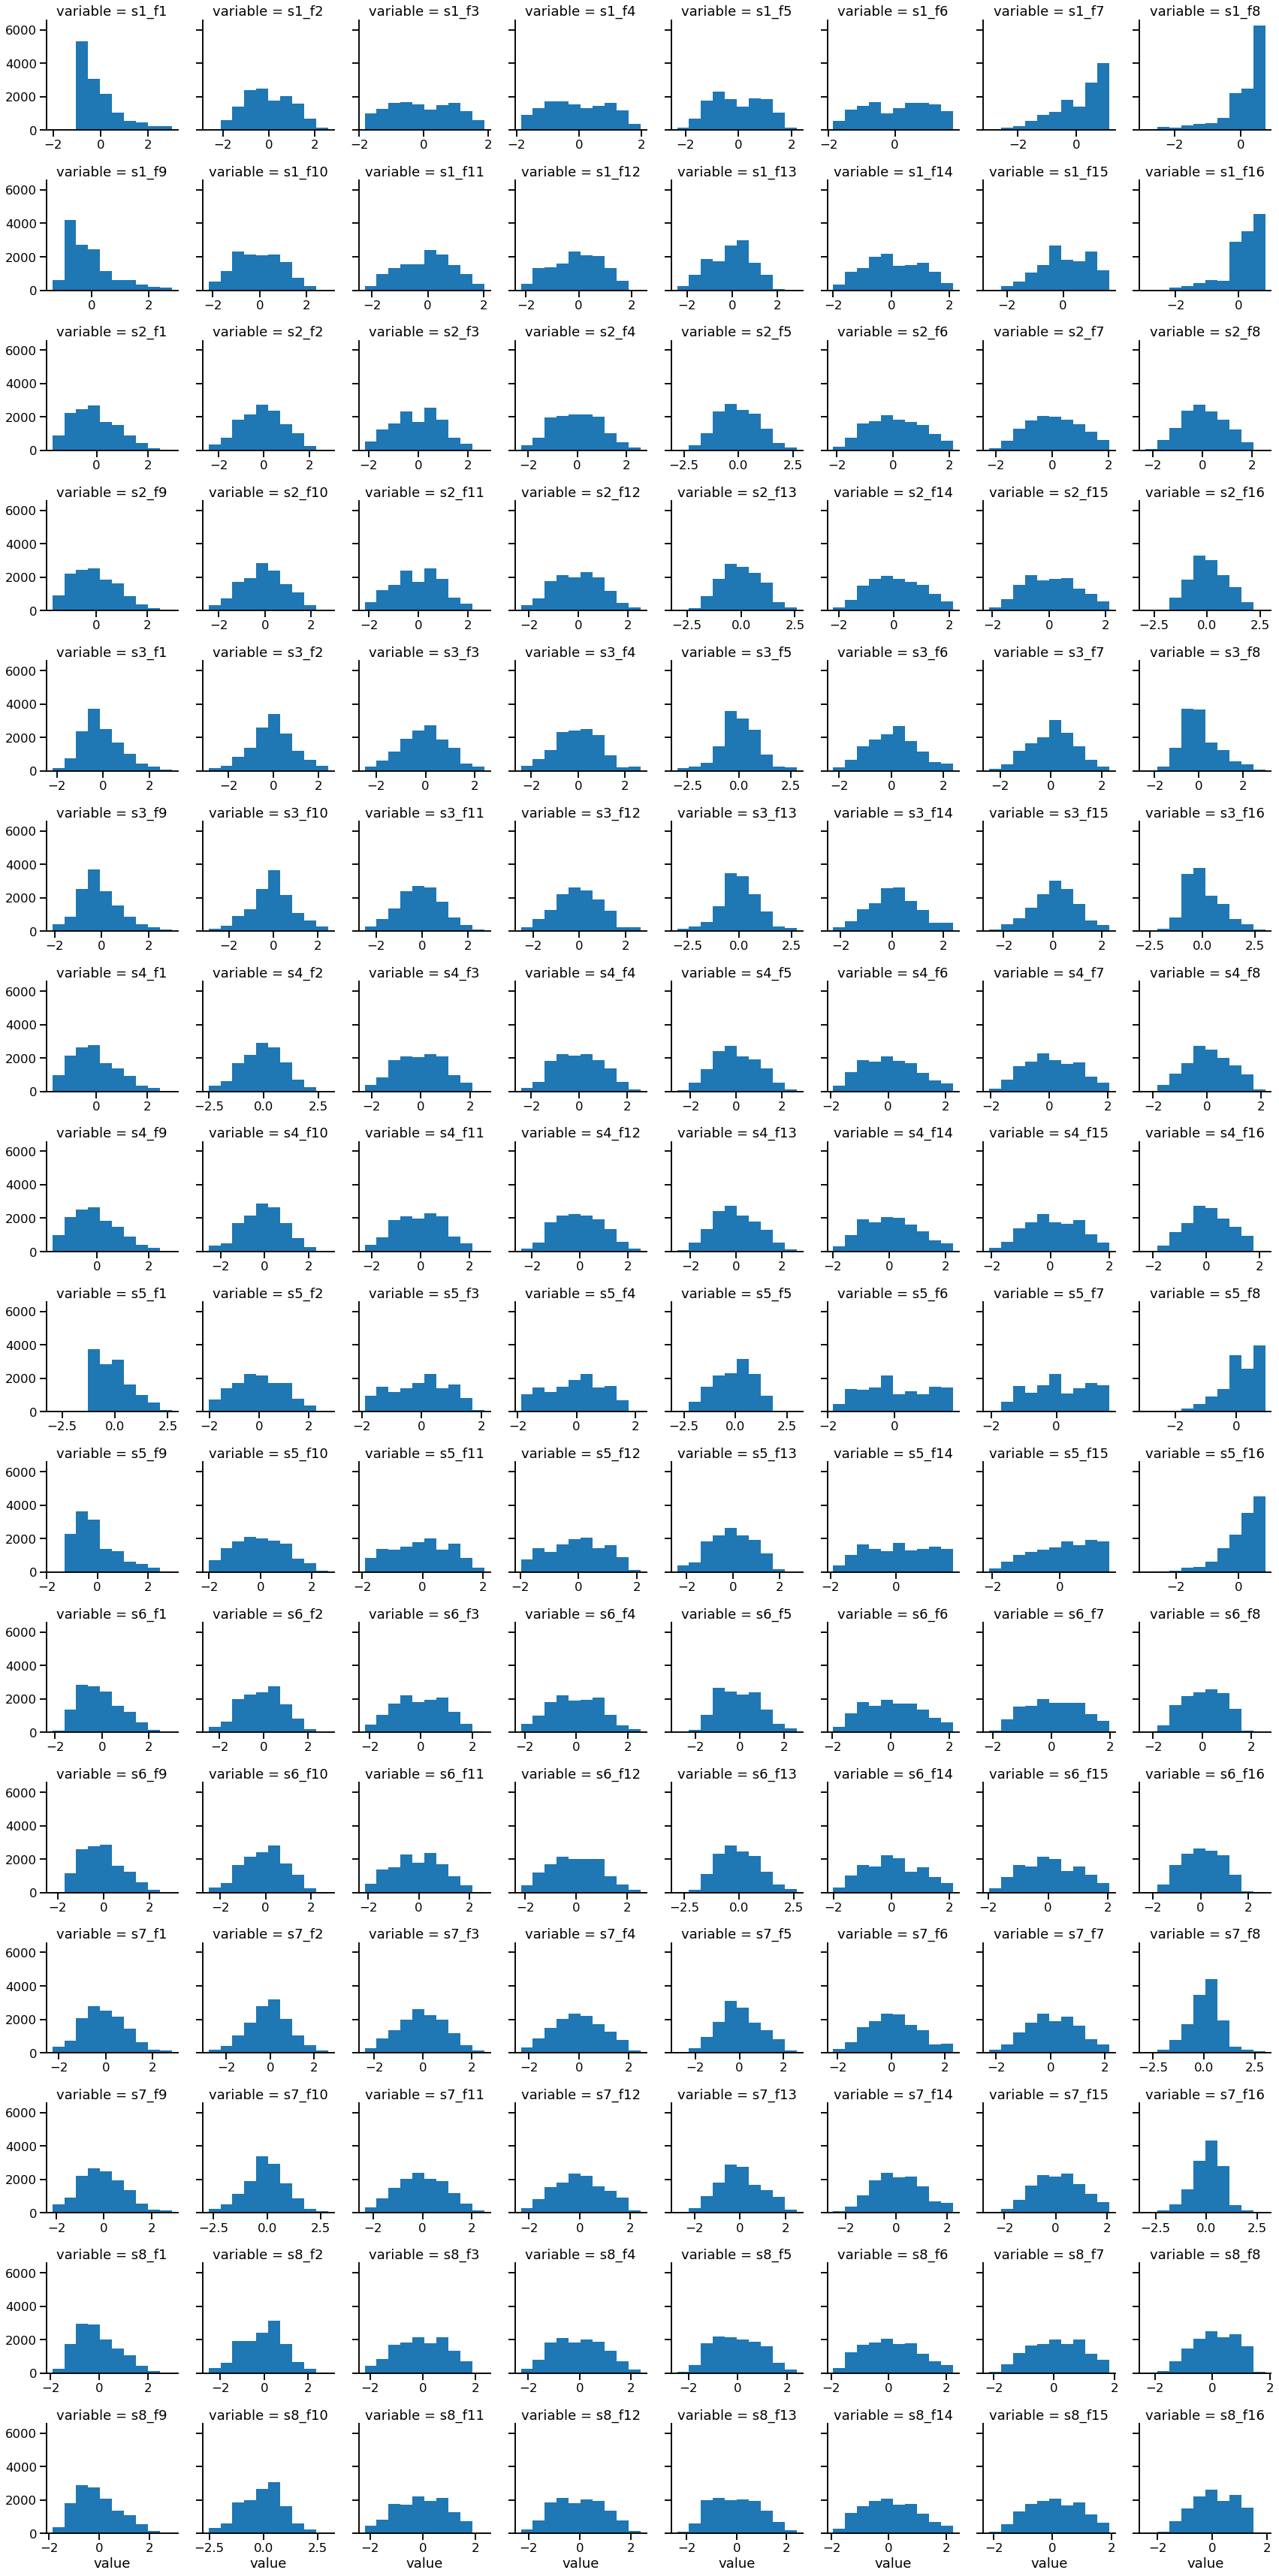

In [39]:
g = sns.FacetGrid(pd.melt(filter_pscale_df), col='variable', col_wrap=8, sharex=False)
g.map(plt.hist,'value')

~5% of the rows have an outlier sensor response. My suspcion on the outliers is that some of the calculations may involve some ratios with small denominators such as the denomiator gets closer to zero, small outliers in the denominator can cause large effects in the calculated response. 

In [40]:
pscale_df[~(np.abs(stats.zscore(pscale_df.loc[:,feature_names])) < 3).all(axis=1)]

,s1_f1,s1_f2,s1_f3,s1_f4,s1_f5,s1_f6,s1_f7,s1_f8,s1_f9,s1_f10,...,s8_f7,s8_f8,s8_f9,s8_f10,s8_f11,s8_f12,s8_f13,s8_f14,s8_f15,s8_f16
0,-0.474921,-1.077574,-0.596575,-0.742282,-0.466153,0.249970,0.506507,0.573790,-0.678991,-1.413318,...,1.475741,1.425974,-1.278044,-0.310130,-2.056028,-2.251763,-2.725971,1.682712,1.573839,1.564726
1,-0.267852,-0.654696,-0.010630,-0.148266,-0.448863,-0.157695,0.228741,0.495612,-0.497154,-1.126729,...,1.296153,1.692093,-1.166545,-0.188371,-1.725075,-1.798267,-2.447467,1.382502,1.363549,1.874050
2,0.000681,-0.231682,0.297370,0.204232,-0.079028,-0.522723,-0.076907,0.381470,-0.233310,-0.734859,...,1.018875,1.465461,-1.006817,0.183750,-1.470854,-1.486287,-1.983884,1.066244,1.086100,1.661149
14,-0.416849,-0.958852,-0.485766,-0.636601,-0.876036,0.165801,0.451498,0.552411,-0.614393,-1.274449,...,1.490885,1.874512,-1.246147,-0.564590,-1.981254,-2.148025,-2.833929,1.593217,1.552304,2.038314
15,-0.155498,-0.501357,0.115506,-0.005238,-0.326466,-0.300418,0.118508,0.439129,-0.365385,-0.875758,...,1.168550,1.486820,-1.056051,-0.045765,-1.539834,-1.580034,-2.154756,1.192943,1.204324,1.744148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13891,2.540976,1.630258,1.728896,1.728733,1.701337,-1.610299,-2.238801,-3.436589,3.193752,1.626387,...,-3.346446,-3.985024,4.066382,2.459544,2.506896,1.868846,1.887319,-2.760008,-3.180484,-3.472328
13895,2.165129,1.545264,1.630215,1.619997,1.663318,-1.541534,-1.852350,-2.868468,2.814180,1.519008,...,-2.927861,-3.236247,3.270570,2.248461,2.091525,1.473179,1.560623,-2.403399,-2.629332,-3.019038
13901,2.254763,1.566265,1.643851,1.625014,1.588292,-1.555236,-1.990618,-2.921527,2.873376,1.542035,...,-2.825598,-2.975603,3.120587,2.242819,2.089224,1.484958,1.510086,-2.384454,-2.666622,-2.808637
13907,1.869689,1.442565,1.512891,1.487022,1.464883,-1.456915,-1.592430,-2.143238,2.489385,1.433285,...,-2.114550,-2.033266,2.072619,1.914288,1.593546,1.075249,1.111515,-1.907935,-2.081593,-2.176643


## Replace outliers by Z-score and replace with imputed values

In [45]:
def filter_z(col):
    col[np.abs(col) > 4] = np.nan
    return col

In [50]:
p_scale_df = pscale_df.apply(lambda col: filter_z(col))

In [49]:
imputer = KNNImputer()

In [52]:
impute_arr = imputer.fit_transform(p_scale_df)

In [53]:
p_scale_df = pd.DataFrame(impute_arr, columns=p_scale_df.columns.values)

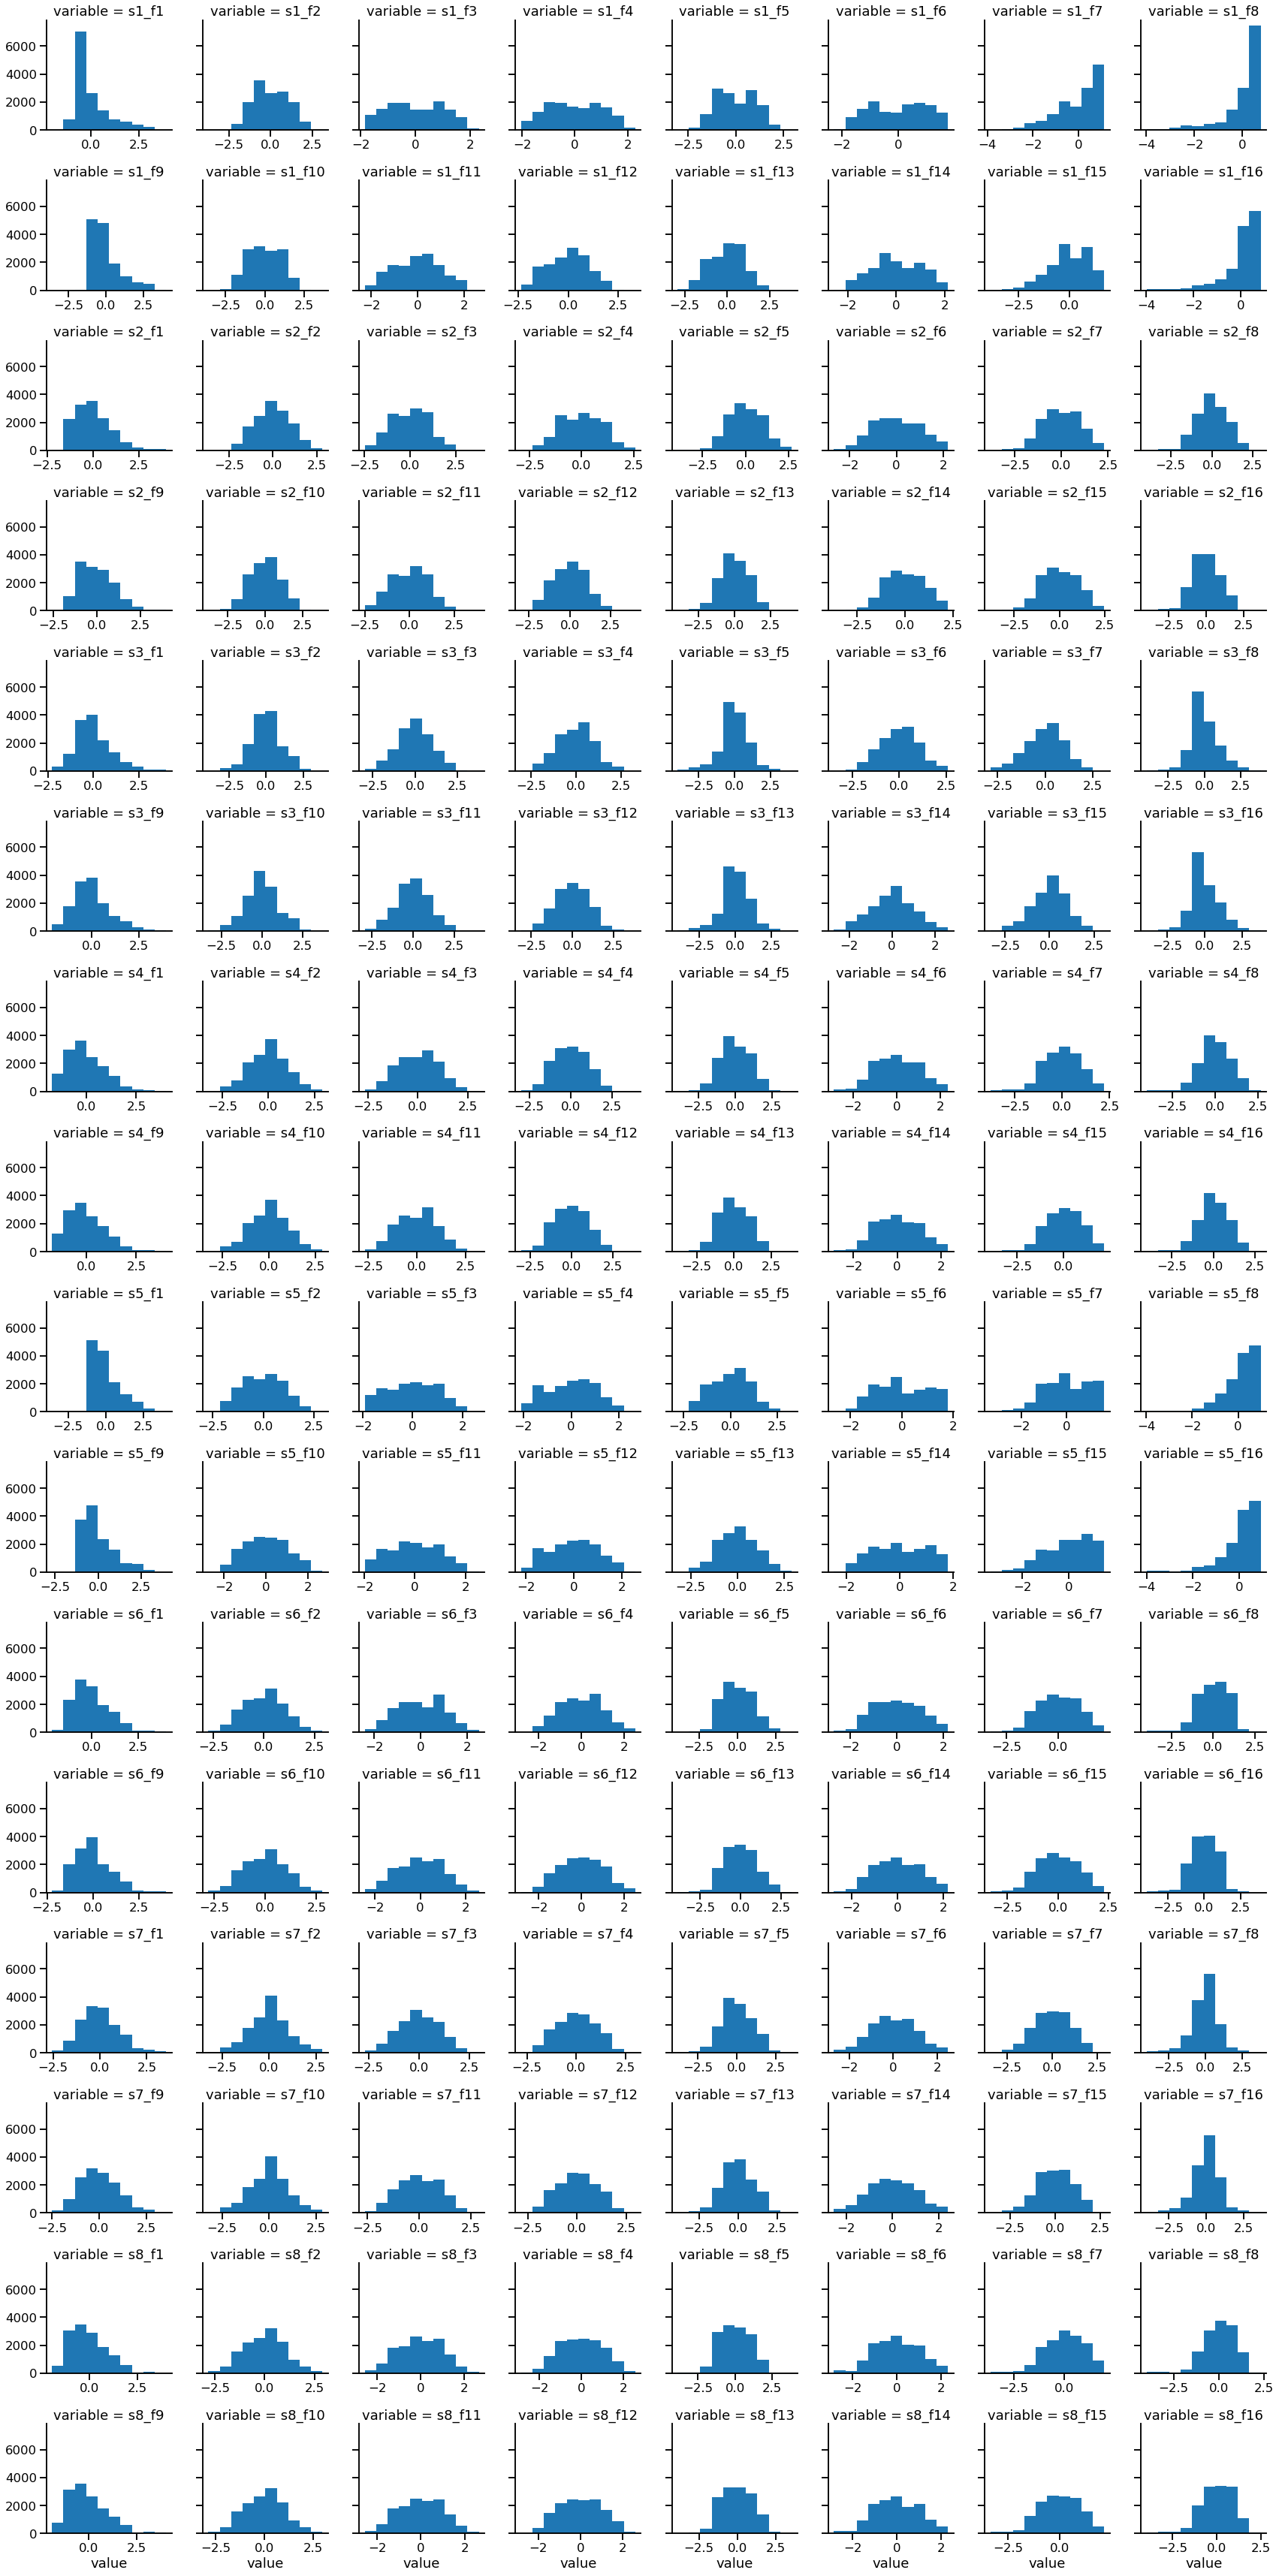

In [54]:
g = sns.FacetGrid(pd.melt(pscale_df), col='variable', col_wrap=8, sharex=False)
g.map(plt.hist,'value')